# Synapse Visualizer

This notebook is modified from Allen Institute tutorial on working with Meshes by Forrest Collman  
The original tutorial is located here:   https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/intro/MeshExample.ipynb  
Updated on Jan 6, 2023 with synapse ids that match Neuroglancer synapse ids

# Python Requirements
You will need to run this notebook in a Python 3.7 environment  
Sometime meshparty will have a conflict with other tools and not work properly in Anaconda  
If that happens, you will need to start over with a new Anaconda environment  
Install allensdk first, then meshparty, then any other other tools desired  
The installation described below worked well:  
* Install new environment v3.7 in Anaconda
* conda install jupyter
* pip install allensdk
* pip install meshparty
* pip install caveclient
* pip install 'itkwidgets[notebook]>=1.0a8'
* pip install --upgrade --pre itk
* pip install gdown

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils

In [3]:
# setup the mesh meta to handle downloads and caching
mesh_dir = 'data/neuron_meshes_v185/' # or change to your desired folder
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)

In [4]:
# enter a cell id of interest (copy and paste from Neuroglancer or a dataframe of interest)

cell_id = 648518346342793912

#some interesting neurons

# 648518346349538440 this excitatory pyramidal neuron has the most total synapses in the volume
# 648518346349539215 this inhibitory basket neuron has the most pre-synaptic sites in the volume
# 648518346349536971 no soma in the volume, appears to have an axon-carrying dendrite
# 648518346349515985 this inhibitory neuron of unknown subtype has 5 pre-synaptic sites that appears to be on dendrites
# 648518346349508279 not a neuron; this is an oligodendrocyte which has synaptic sites most likely due to mis-segmentation
# 648518346349537741 the largest continous mitochondrion by voxels, for an excitatory pyramidal neuron in the volume
# 648518346349538791 the largest continous mitochondrion by voxels, for an inhibitory neuron in the volume (basket) 
# 648518346349537611 partial excitatory pyramidal neuron with interesting mitochondria and synapse features
# 648518346349538179 Martinotti inhibitory neuron
# 648518346349540055 Excitatory pyramidal neuron with 9 pre-syn sites not located on the axon
# 648518346349538789 Inhibitory neurogliaform interneuron
# 648518346349527116 Partial pyramidal neuron listed as unknown in soma valence table; suspicious pre-syn sites (4)
# 648518346349536938 a partial axon and basal dendrite from a soma near but outside the volume; a large # of synapses in the volume
# 648518346349537042 interesting pyramidal neuron
# 648518346349527116 partial pyramidal neuron in the corner of a volume
# 648518346349539887 pyramidal neuron
# 648518346349538157 pyramidal neuron slightly off axis
# 648518346342793912 long apical dendrite from L4-6 with a prominent axon-carrying dendrite

In [5]:
# If you get an error, run the next cell to download the mesh, then rerun this cell again
seg_id = cell_id
mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
mesh = mm.mesh(filename = mesh_file)

In [6]:
# If you get an error on the previous cell, run this cell
# After the mesh is successfully downloaded, rerun the previous cell 
downloadmesh = mm.mesh(seg_id = seg_id, remove_duplicate_vertices=True)

In [7]:
seg_id

648518346342793912

In [8]:
mesh_file

'data/neuron_meshes_v185/648518346342793912.h5'

In [9]:
mesh.n_vertices, mesh.n_faces

(314049, 628298)

In [10]:
# read in the full synapse table
soma_subgraph_df = pd.read_csv('data/221206_pni_synapses_v185.csv')

In [11]:
soma_subgraph_df

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2477272,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,4538436,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,1124039,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,5245264,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,6928613,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239270,2167340,648518346348045782,648518346349537840,106,268776,173356,14360,67190,43302,361,67194,43339,359,67216,43364,360
3239271,1944654,648518346347834064,648518346349537840,50,267344,156520,8520,66762,39152,213,66836,39130,213,66874,39134,213
3239272,2749491,648518346347876810,648518346349537840,139,292772,156680,12600,73136,39170,315,73193,39170,315,73218,39160,315
3239273,6924909,648518346348343883,648518346349537840,987,462768,237776,8520,115680,59370,208,115692,59444,213,115628,59430,214


In [12]:
# filter all the pre- and post- synapses for this cell
cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}') #this shows all post-syn sites on this seg_id cell
cell_pre_subgraph = soma_subgraph_df.query(f'pre_root_id=={seg_id}') #this one shows all pre-syn sites on the axon of seg_id cell

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values
presyn_xyz=cell_pre_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

(309224.90625, 158263.828125)

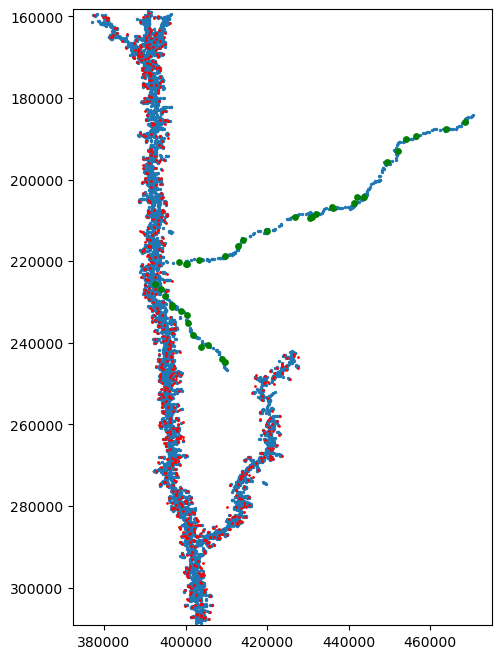

In [13]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=1) # modify s and alpha to improve the visualization

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='red', s=1, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

ax.scatter(presyn_xyz[:,0], presyn_xyz[:,1], c='green', s=15, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [14]:
len(postsyn_xyz)

680

In [15]:
len(presyn_xyz)

36

In [16]:
# Make a list of the pre_root_ids that form a synapse on this cell
cell_post_subgraph

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
1246,5541018,648518346342921920,648518346342793912,62,401344,279048,58560,100332,69714,1465,100336,69762,1464,100316,69794,1465
5985,5306722,648518346341403453,648518346342793912,67,396144,258616,57080,99056,64670,1429,99036,64654,1427,99004,64622,1429
6069,5296470,648518346342929975,648518346342793912,1094,398404,251844,54560,99740,62964,1365,99601,62961,1364,99724,62884,1365
15067,5755598,648518346341403507,648518346342793912,2036,410048,287120,55160,102494,71860,1381,102512,71780,1379,102454,71766,1381
15987,5022075,648518346342919917,648518346342793912,63,390232,190568,40000,97524,47648,1000,97558,47642,1000,97598,47614,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799519,5574347,648518346342764327,648518346342793912,189,402756,306636,63560,100658,76684,1590,100689,76659,1589,100682,76640,1591
2800316,5021770,648518346346297110,648518346342793912,60,389512,188984,37640,97342,47236,940,97378,47246,941,97416,47266,942
2811520,5285095,648518346342801818,648518346342793912,61,396488,243456,50760,99118,60894,1269,99122,60864,1269,99148,60832,1270
2826793,5929529,648518346349524139,648518346342793912,294,417776,271280,39880,104428,67850,998,104444,67820,997,104418,67784,998


In [17]:
# Uncomment if you want to generate a list for copy and pasting
# cell_post_subgraph["pre_root_id"].to_list()

In [18]:
# Make a list of the post_root_ids that receive a synapse from this cell
cell_pre_subgraph

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
66271,6271825,648518346342793912,648518346349386035,609,436180,206868,57240,109036,51726,1428,109045,51717,1431,108970,51710,1429
80729,5683488,648518346342793912,648518346349093634,75,408912,244048,4960,102258,60978,121,102228,61012,124,102160,61054,121
131534,5659387,648518346342793912,648518346349538053,761,412784,216272,51400,103214,54096,1282,103196,54068,1285,103120,54078,1282
141747,5464047,648518346342793912,648518346349503588,77,400384,220600,45640,100074,55160,1142,100096,55150,1141,100104,55184,1140
155845,6863961,648518346342793912,648518346348193777,710,463784,187616,76760,115900,46906,1926,115946,46904,1919,115860,46828,1926
199784,6063116,648518346342793912,648518346348302759,194,430988,209196,55640,107674,52310,1393,107747,52299,1391,107762,52272,1393
301239,5684015,648518346342793912,648518346349093688,95,409760,244768,5640,102450,61172,139,102440,61192,141,102430,61218,141
316128,6479653,648518346342793912,648518346342795643,244,442112,204376,62600,110532,51090,1563,110528,51094,1565,110456,51156,1563
373421,6271692,648518346342793912,648518346348212377,106,435800,206728,56400,108944,51738,1411,108950,51682,1410,108940,51656,1411
408370,6479199,648518346342793912,648518346348300656,107,441360,205776,60400,110362,51500,1509,110340,51444,1510,110326,51416,1509


In [19]:
# Uncomment if you will to generate a list for copy and pasting
# cell_pre_subgraph["post_root_id"].to_list()

In [20]:
# 3D visualizer using OpenGL and vtk tool
# You must have OpenGL installed on your computer

import vtk

In [21]:
# Use this visualization if you do NOT want to see the synaptic sites (cell mesh only)

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.2, 0.4, 0.7)) #adjust color if desired

#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x0000024451BE69F0) at 0x00000244025F5468>

In [22]:
# Use this visualization if you want to see the synaptic sites

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.2, 0.4, 0.7)) #adjust color if desired
presyn_actor = trimesh_vtk.point_cloud_actor(presyn_xyz, size=500, color=(0.2, 0.9, 0.2)) #adjust size and color if desired 
postsyn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=250, color=(0.9, 0.2, 0.2)) #adjust size and color if desired


#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor,presyn_actor, postsyn_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x0000024451BE7690) at 0x00000244025C4F48>